In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-complex

In [ ]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
import complexnn
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Flatten, Dropout, MaxPool2D, LeakyReLU, GlobalAveragePooling2D, Reshape
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pickle

# Original Data

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/facial-keypoints-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('facial-keypoints-detection')

In [ ]:
with zipfile.ZipFile('/content/facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/facial-keypoints-detection/test')

with zipfile.ZipFile('/content/facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/facial-keypoints-detection/training')

In [ ]:
train = pd.read_csv('/content/facial-keypoints-detection/training/training.csv')
test = pd.read_csv('/content/facial-keypoints-detection/test/test.csv')
id = pd.read_csv('/content/facial-keypoints-detection/IdLookupTable.csv')

In [ ]:
print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


In [ ]:
train.head(3).T

0  \
left_eye_center_x                                                  66.033564   
left_eye_center_y                                                  39.002274   
right_eye_center_x                                                 30.227008   
right_eye_center_y                                                 36.421678   
left_eye_inner_corner_x                                            59.582075   
left_eye_inner_corner_y                                            39.647423   
left_eye_outer_corner_x                                            73.130346   
left_eye_outer_corner_y                                            39.969997   
right_eye_inner_corner_x                                           36.356571   
right_eye_inner_corner_y                                           37.389402   
right_eye_outer_corner_x                                           23.452872   
right_eye_outer_corner_y                                           37.389402   
left_eyebrow_inner_end_x                                           56.953263   
left_eyebrow_inner_end_y                                           29.033648   
left_eyebrow_outer_end_x                                           80.227128   
left_eyebrow_outer_end_y                                           32.228138   
right_eyebrow_inner_end_x                                          40.227609   
right_eyebrow_inner_end_y                                          29.002322   
right_eyebrow_outer_end_x                                          16.356379   
right_eyebrow_outer_end_y                                          29.647471   
nose_tip_x                                                         44.420571   
nose_tip_y                                                         57.066803   
mouth_left_corner_x                                                61.195308   
mouth_left_corner_y                                                79.970165   
mouth_right_corner_x                                               28.614496   
mouth_right_corner_y                                               77.388992   
mouth_center_top_lip_x                                             43.312602   
mouth_center_top_lip_y                                             72.935459   
mouth_center_bottom_lip_x                                          43.130707   
mouth_center_bottom_lip_y                                          84.485774   
Image                      238 236 237 238 240 240 239 241 241 243 240 23...   

                                                                           1  \
left_eye_center_x                                                  64.332936   
left_eye_center_y                                                  34.970077   
right_eye_center_x                                                 29.949277   
right_eye_center_y                                                 33.448715   
left_eye_inner_corner_x                                             58.85617   
left_eye_inner_corner_y                                            35.274349   
left_eye_outer_corner_x                                            70.722723   
left_eye_outer_corner_y                                            36.187166   
right_eye_inner_corner_x                                           36.034723   
right_eye_inner_corner_y                                           34.361532   
right_eye_outer_corner_x                                           24.472511   
right_eye_outer_corner_y                                           33.144443   
left_eyebrow_inner_end_x                                           53.987404   
left_eyebrow_inner_end_y                                           28.275949   
left_eyebrow_outer_end_x                                           78.634213   
left_eyebrow_outer_end_y                                           30.405923   
right_eyebrow_inner_end_x                                          42.728851   
right_eyebrow_inner_end_y                                          26.1460

In [ ]:
display(test.head())

ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2        3  177 176 174 170 169 169 168 166 166 166 161 14...
3        4  176 174 174 175 174 174 176 176 175 171 165 15...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...

In [ ]:
display(id.head())

RowId  ImageId              FeatureName  Location
0      1        1        left_eye_center_x       NaN
1      2        1        left_eye_center_y       NaN
2      3        1       right_eye_center_x       NaN
3      4        1       right_eye_center_y       NaN
4      5        1  left_eye_inner_corner_x       NaN

In [ ]:
complete_train = train[~train.isnull().any(axis=1)]
incomplete_train = train[train.isnull().any(axis=1)]

print(f"Samples with 15 keypoints: {len(complete_train)}")
print(f"Samples with 4 keypoints: {len(incomplete_train)}")

Samples with 15 keypoints: 2140
Samples with 4 keypoints: 4909


In [ ]:
def process_training_data(data):
    images = []
    keypoints = []
    for idx, sample in data.iterrows():
      image = np.reshape(np.array(sample['Image'].split(' '), dtype=int), (96,96,1))
      images.append(image)
      keypoints.append(sample.drop('Image'))

    keypoints = np.array(keypoints, dtype = 'float')
    images = np.array(images)/255.
    return images, keypoints

X_train, y_train = process_training_data(complete_train)

print(X_train.shape)
print(y_train.shape)

(2140, 96, 96, 1)
(2140, 30)


In [30]:
def process_test_data(data):
    images = []
    for idx, sample in data.iterrows():
      image = np.reshape(np.array(sample['Image'].split(' '), dtype=int),(96,96,1))
      images.append(image)

    images = np.array(images)/255.
    return images

X_test = process_test_data(test)

# Saves

In [ ]:
np.save('X_train.npy', X_train)

# To verify, you can load the file back and check its shape
loaded_X_train = np.load('X_train.npy')
print(loaded_X_train.shape)

(2140, 96, 96, 1)


In [ ]:
X_train_flat = X_train.reshape((2140, -1))
df = pd.DataFrame(X_train_flat)
df.to_csv('X_train.csv', index=False)

In [ ]:
X_test_flat = X_test.reshape((1783, -1))
df = pd.DataFrame(X_test_flat)
df.to_csv('X_test.csv', index=False)

NameError: name 'X_test' is not defined

# Dummy Data

In [ ]:
imaginary_part = np.zeros_like(X_train)
complex_X_train = np.concatenate((X_train,imaginary_part), axis=-1)
print(complex_X_train.shape)

complex_y_train = np.zeros((y_train.shape[0], y_train.shape[1], 2), dtype=np.float32)
complex_y_train[:, :, 0] = y_train
print(complex_y_train.shape)

real_part = complex_y_train[:, :, 0]
imag_part = complex_y_train[:, :, 1]
complex_y_train = np.concatenate((real_part, imag_part), axis=1)
print(complex_y_train.shape)

(2140, 96, 96, 2)
(2140, 30, 2)
(2140, 60)


In [ ]:
def process_test_data(data):
    images = []
    for idx, sample in data.iterrows():
      image = np.reshape(np.array(sample['Image'].split(' '), dtype=int),(96,96,1))
      images.append(image)

    images = np.array(images)/255.
    return images

X_test = process_test_data(test)
imaginary_part = np.zeros_like(X_test)
complex_X_test = np.concatenate((X_test,imaginary_part), axis=-1)
print(complex_X_test.shape)

(1783, 96, 96, 2)


In [ ]:
easymodel = Sequential()

easymodel.add(complexnn.conv.ComplexConv2D(16, (3,3), padding='same', use_bias=False, input_shape=(96,96,2)))
easymodel.add(LeakyReLU(alpha=0.1))
easymodel.add(complexnn.bn.ComplexBatchNormalization())
easymodel.add(MaxPool2D(pool_size=(2, 2)))

easymodel.add(complexnn.conv.ComplexConv2D(32, (1,1), padding='same', use_bias=False))
easymodel.add(LeakyReLU(alpha=0.1))
easymodel.add(complexnn.bn.ComplexBatchNormalization())
easymodel.add(MaxPool2D(pool_size=(2, 2)))

easymodel.add(complexnn.conv.ComplexConv2D(64, (3,3), padding='same', use_bias=False))
easymodel.add(LeakyReLU(alpha=0.1))
easymodel.add(complexnn.bn.ComplexBatchNormalization())
easymodel.add(MaxPool2D(pool_size=(2, 2)))

easymodel.add(complexnn.conv.ComplexConv2D(128, (3,3), padding='same', use_bias=False))
easymodel.add(LeakyReLU(alpha=0.1))
easymodel.add(complexnn.bn.ComplexBatchNormalization())
easymodel.add(MaxPool2D(pool_size=(2, 2)))

easymodel.add(complexnn.conv.ComplexConv2D(256, (3,3), padding='same', use_bias=False))
easymodel.add(LeakyReLU(alpha=0.1))
easymodel.add(complexnn.bn.ComplexBatchNormalization())
easymodel.add(MaxPool2D(pool_size=(2, 2)))

easymodel.add(complexnn.conv.ComplexConv2D(512, (3,3), padding='same', use_bias=False))
easymodel.add(LeakyReLU(alpha=0.1))
easymodel.add(complexnn.bn.ComplexBatchNormalization())

easymodel.add(Flatten())
easymodel.add(Dense(256,activation='relu'))
easymodel.add(Dropout(0.5))
easymodel.add(Dense(30, activation='linear'))

easymodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_conv2d_14 (Complex  (None, 96, 96, 32)        288       
 Conv2D)                                                         
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 96, 96, 32)        0         
                                                                 
 complex_batch_normalizatio  (None, 96, 96, 32)        160       
 n_12 (ComplexBatchNormaliz                                      
 ation)                                                          
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 complex_conv2d_15 (Complex  (None, 48, 48, 64)       

# Final Data

In [ ]:
def rearrange_row(row):
    even_indices = row[::2]  # Select elements at even indices
    odd_indices = row[1::2]  # Select elements at odd indices
    return np.concatenate((even_indices, odd_indices))

new_y_train = np.apply_along_axis(rearrange_row, 1, y_train)
print(new_y_train.shape)

(2140, 30)


In [ ]:
X_train_real = np.load('/content/drive/MyDrive/FCR_final.npy')
X_train_imag = np.load('/content/drive/MyDrive/FCI_final.npy')
X_test_real = np.load('/content/drive/MyDrive/FCR_test.npy')
X_test_imag = np.load('/content/drive/MyDrive/FCI_test.npy')
print(X_train_real.shape)
print(X_train_imag.shape)
print(X_test_real.shape)
print(X_test_imag.shape)

(2140, 96, 96)
(2140, 96, 96)
(1783, 96, 96)
(1783, 96, 96)


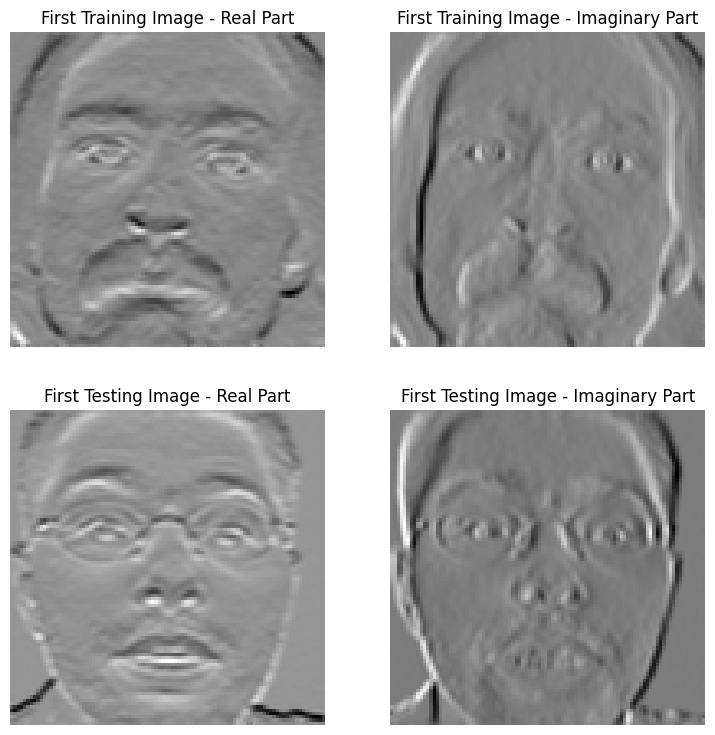

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

first_image_train_real = X_train_real[0, :, :]
first_image_train_imag = X_train_imag[0, :, :]
first_image_test_real = X_test_real[0, :, :]
first_image_test_imag = X_test_imag[0, :, :]

axs[0, 0].imshow(first_image_train_real, cmap='gray')
axs[0, 0].set_title('First Training Image - Real Part')
axs[0, 0].axis('off')

axs[0, 1].imshow(first_image_train_imag, cmap='gray')
axs[0, 1].set_title('First Training Image - Imaginary Part')
axs[0, 1].axis('off')

axs[1, 0].imshow(first_image_test_real, cmap='gray')
axs[1, 0].set_title('First Testing Image - Real Part')
axs[1, 0].axis('off')

axs[1, 1].imshow(first_image_test_imag, cmap='gray')
axs[1, 1].set_title('First Testing Image - Imaginary Part')
axs[1, 1].axis('off')

plt.show()

In [ ]:
X_train_final = np.stack((X_train_real, X_train_imag), axis=-1)
X_test_final = np.stack((X_test_real, X_test_imag), axis=-1)
print(X_train_final.shape)
print(X_test_final.shape)

(2140, 96, 96, 2)
(1783, 96, 96, 2)


# Model

In [ ]:
model = Sequential()

model.add(complexnn.conv.ComplexConv2D(16, (3,3), padding='same', use_bias=False, input_shape=(96,96,2)))
model.add(LeakyReLU(alpha=0.1))
model.add(complexnn.bn.ComplexBatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(complexnn.conv.ComplexConv2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(complexnn.bn.ComplexBatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(complexnn.conv.ComplexConv2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(complexnn.bn.ComplexBatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(complexnn.conv.ComplexConv2D(128, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(complexnn.bn.ComplexBatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(complexnn.conv.ComplexConv2D(256, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(complexnn.bn.ComplexBatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(complexnn.conv.ComplexConv2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(complexnn.bn.ComplexBatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(complexnn.conv.ComplexConv2D(128, (1,1), activation='relu', padding='valid'))
model.add(Dropout(0.5))
model.add(complexnn.conv.ComplexConv2D(15, (1,1), activation='linear', padding='valid'))
model.add(GlobalAveragePooling2D())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_conv2d (ComplexCon  (None, 96, 96, 32)        288       
 v2D)                                                            
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 complex_batch_normalizatio  (None, 96, 96, 32)        160       
 n (ComplexBatchNormalizati                                      
 on)                                                             
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 complex_conv2d_1 (ComplexC  (None, 48, 48, 64)        9

In [ ]:
from sklearn.model_selection import train_test_split
X_training, X_validation, y_training, y_validation = train_test_split(X_train_final, new_y_train, test_size=0.05, random_state=42)
optimizer = Adam(learning_rate= 1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'acc'])
es = EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(X_training, y_training, epochs = 20,  batch_size = 128, validation_data=(X_validation, y_validation), callbacks=[es])

Epoch 1/20
16/16 [==============================] - 40s 2s/step - loss: 1709.7178 - mae: 35.7154 - acc: 0.0635 - val_loss: 225.2016 - val_mae: 12.2665 - val_acc: 0.0000e+00
Epoch 2/20
16/16 [==============================] - 31s 2s/step - loss: 174.1198 - mae: 10.7831 - acc: 0.3025 - val_loss: 85.9588 - val_mae: 8.1497 - val_acc: 0.7103
Epoch 3/20
16/16 [==============================] - 31s 2s/step - loss: 67.7686 - mae: 6.5619 - acc: 0.6458 - val_loss: 15.1343 - val_mae: 3.0677 - val_acc: 0.7103
Epoch 4/20
16/16 [==============================] - 30s 2s/step - loss: 43.2434 - mae: 5.0542 - acc: 0.6119 - val_loss: 10.8545 - val_mae: 2.4830 - val_acc: 0.7196
Epoch 5/20
16/16 [==============================] - 31s 2s/step - loss: 38.2400 - mae: 4.7690 - acc: 0.6237 - val_loss: 9.3161 - val_mae: 2.2435 - val_acc: 0.7196
Epoch 6/20
16/16 [==============================] - 31s 2s/step - loss: 37.5733 - mae: 4.7190 - acc: 0.6237 - val_loss: 9.6197 - val_mae: 2.3066 - val_acc: 0.7196
Epoch 7

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(X_train_final, new_y_train, test_size=0.2, random_state=42)

val_predictions = model.predict(X_val)

if len(y_val.shape) == 1 or y_val.shape[1] == 1:
    val_predictions_classes = (val_predictions > 0.5).astype(int)
    y_val_classes = (y_val > 0.5).astype(int)
else:
    # Example for Multi-Class Classification
    # Convert predictions to class labels
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    # Convert y_val to class labels if it is one-hot encoded
    if y_val.ndim == 2:
        y_val_classes = np.argmax(y_val, axis=1)
    else:
        y_val_classes = y_val

# Calculate accuracy
val_accuracy = accuracy_score(y_val_classes, val_predictions_classes)

print(f'Validation Accuracy: {val_accuracy}')


14/14 [==============================] - 3s 96ms/step
Validation Accuracy: 0.7336448598130841


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score

# If your target variable is continuous (regression task), you can use r2_score
if len(y_val.shape) == 1 or y_val.shape[1] == 1:
    r2 = r2_score(y_val, val_pred)
    print(f'R2 Score: {r2}')

# If your target variable is categorical (classification task), you can use precision, recall, and f1-score
else:
    # Assuming y_val and val_pred are one-hot encoded, get the class with the highest probability
    y_val_classes = y_val.argmax(axis=1)
    val_pred_classes = val_predictions.argmax(axis=1)

    precision = precision_score(y_val_classes, val_pred_classes, average='weighted')
    recall = recall_score(y_val_classes, val_pred_classes, average='weighted')
    f1 = f1_score(y_val_classes, val_pred_classes, average='weighted')

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')


Precision: 0.7233630347709991
Recall: 0.7336448598130841
F1 Score: 0.6473035863536206


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
test_pred = model.predict(X_test_final)

56/56 [==============================] - 5s 98ms/step


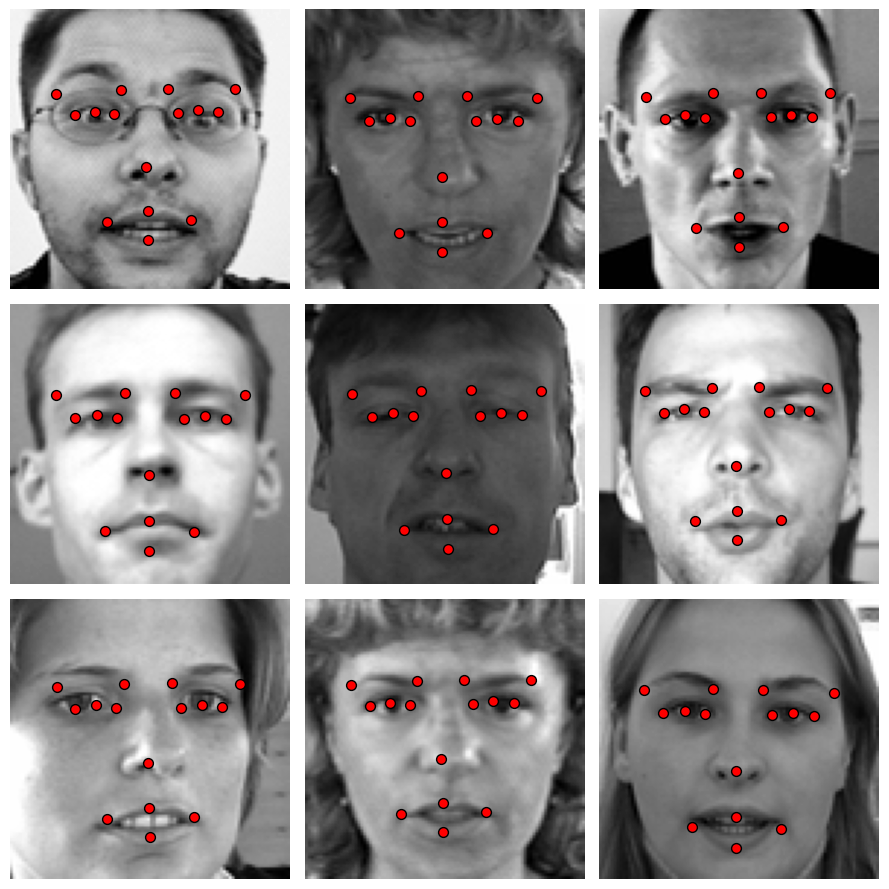

In [38]:
images = X_test
def plot_points_on_image(image, points, ax):
    ax.imshow(image, cmap='gray')
    x_points = points[:15]
    y_points = points[15:]
    ax.scatter(x_points, y_points, color='red', edgecolors='black', s=50, linewidths=1)
    ax.axis('off')

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        plot_points_on_image(images[i], test_pred[i], ax)

plt.tight_layout()

plt.savefig('FCCN_output.png')
plt.show()

In [37]:
model.save('complex_conv_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Excess

In [ ]:
images = complex_X_test[:, :, :, 0]
def plot_points_on_image(image, points, ax):
    ax.imshow(image, cmap='gray')
    x_points = points[:15]
    y_points = points[15:]
    ax.scatter(x_points, y_points, color='blue')
    ax.axis('off')

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        plot_points_on_image(images[i], test_pred[i], ax)

plt.tight_layout()
plt.show()

In [ ]:
from keras import backend as K

X = complex_X_train[0]
X = np.expand_dims(X, axis=0)

def get_layer_output(layer_idx):
  get_layer_output = K.function(
    [model.layers[0].input],
    [model.layers[layer_idx].output]
  )

  output = get_layer_output([X])[0]
  return output

# here X is param 1 (input) and the function returns output from layers[3]
output = get_layer_output(19)
print(output.shape)

(1, 3, 3, 512)


56/56 [==============================] - 6s 107ms/step


<ipython-input-29-460804a43f1e>:38: RuntimeWarning: invalid value encountered in divide
  grayscale_image = imag_part / np.max(imag_part)


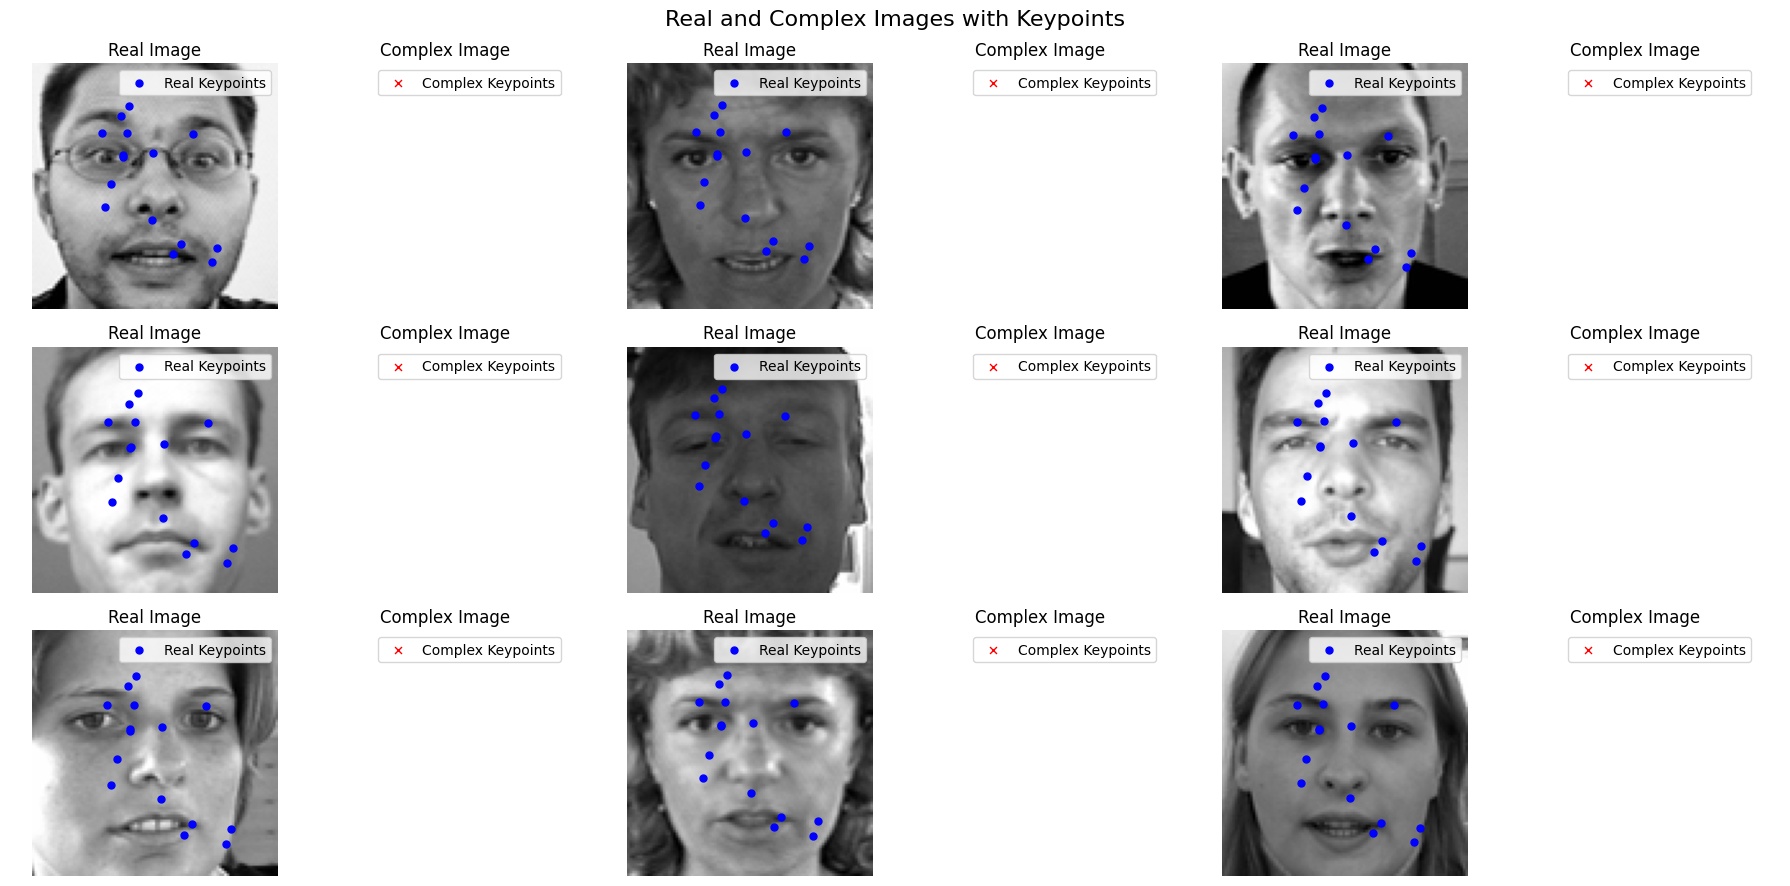

In [ ]:
def process_test_data(data):
    images = []
    for idx, sample in data.iterrows():
      image = np.reshape(np.array(sample['Image'].split(' '), dtype=int),(96,96,1))
      images.append(image)

    images = np.array(images)/255.
    return images

X_test = process_test_data(test)
imaginary_part = np.zeros_like(X_test)
complex_X_test = np.concatenate((X_test,imaginary_part), axis=-1)

test_pred = model.predict(complex_X_test)

fig, axs = plt.subplots(3, 3, figsize=(18, 9), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    sample = complex_X_test[i]
    real_part = sample[:, :, 0]
    imag_part = sample[:, :, 1]

    ax.axis('off')

    real_ax = ax.inset_axes([0, 0, 0.5, 1])
    real_ax.imshow(real_part, cmap='gray')
    real_ax.axis('off')
    real_ax.set_title('Real Image')

    # Plot the real keypoints
    real_keypoints = test_pred[i, :30]
    x_coords_real = real_keypoints[::2]
    y_coords_real = real_keypoints[1::2]
    real_ax.scatter(x_coords_real, y_coords_real, s=25, c='blue', marker='o', linewidths=1, label='Real Keypoints')
    real_ax.legend()

    complex_ax = ax.inset_axes([0.5, 0, 0.5, 1])
    grayscale_image = imag_part / np.max(imag_part)
    complex_ax.imshow(grayscale_image)
    complex_ax.axis('off')
    complex_ax.set_title('Complex Image')

    imag_keypoints = test_pred[i, 30:]
    x_coords_imag = imag_keypoints[::2]
    y_coords_imag = imag_keypoints[1::2]
    complex_ax.scatter(x_coords_imag, y_coords_imag, s=25, c='red', marker='x', linewidths=1, label='Complex Keypoints')
    complex_ax.legend()

plt.suptitle('Real and Complex Images with Keypoints', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
print(X.shape)

(1, 96, 96, 2)


In [ ]:
print(output)

[[[[-0.42616627  1.971389   -0.6715271  ... -0.45266435  1.8351353
     0.4267476 ]
   [-0.3923595   0.12789558 -0.5683671  ... -0.48341236  0.35485303
     0.22076857]
   [ 0.12752865 -0.04003883 -0.48147136 ... -0.0382036   0.04109552
     0.46913594]]

  [[-0.45494545  1.2633948   0.78014904 ... -0.5681652   1.1977102
    -0.0325161 ]
   [ 1.5862082  -0.39530295  0.56103396 ...  0.63076955 -0.39096516
    -0.28910112]
   [ 1.3660187  -0.36025918  0.75867087 ...  1.372627   -0.30358088
     0.39409506]]

  [[-0.36950234  0.48267612  0.8680669  ...  0.18021266  0.621389
     0.08647163]
   [ 1.7445056  -0.3463635   0.38878572 ...  0.32349682 -0.36247694
     0.28179455]
   [ 0.92573833 -0.240191    0.169582   ...  1.378938   -0.26268226
     0.40461603]]]]


In [ ]:
cc1 = get_layer_output(1)
lr1 = get_layer_output(2)
cbn1 = get_layer_output(3)
mx1 = get_layer_output(4)

cc2 = get_layer_output(5)
lr2 = get_layer_output(6)
cbn2 = get_layer_output(7)
mx2 = get_layer_output(8)

cc3 = get_layer_output(9)
lr3 = get_layer_output(10)
cbn3 = get_layer_output(11)
mx3 = get_layer_output(12)

cc4 = get_layer_output(13)
lr4 = get_layer_output(14)
cbn4 = get_layer_output(15)
mx4 = get_layer_output(16)



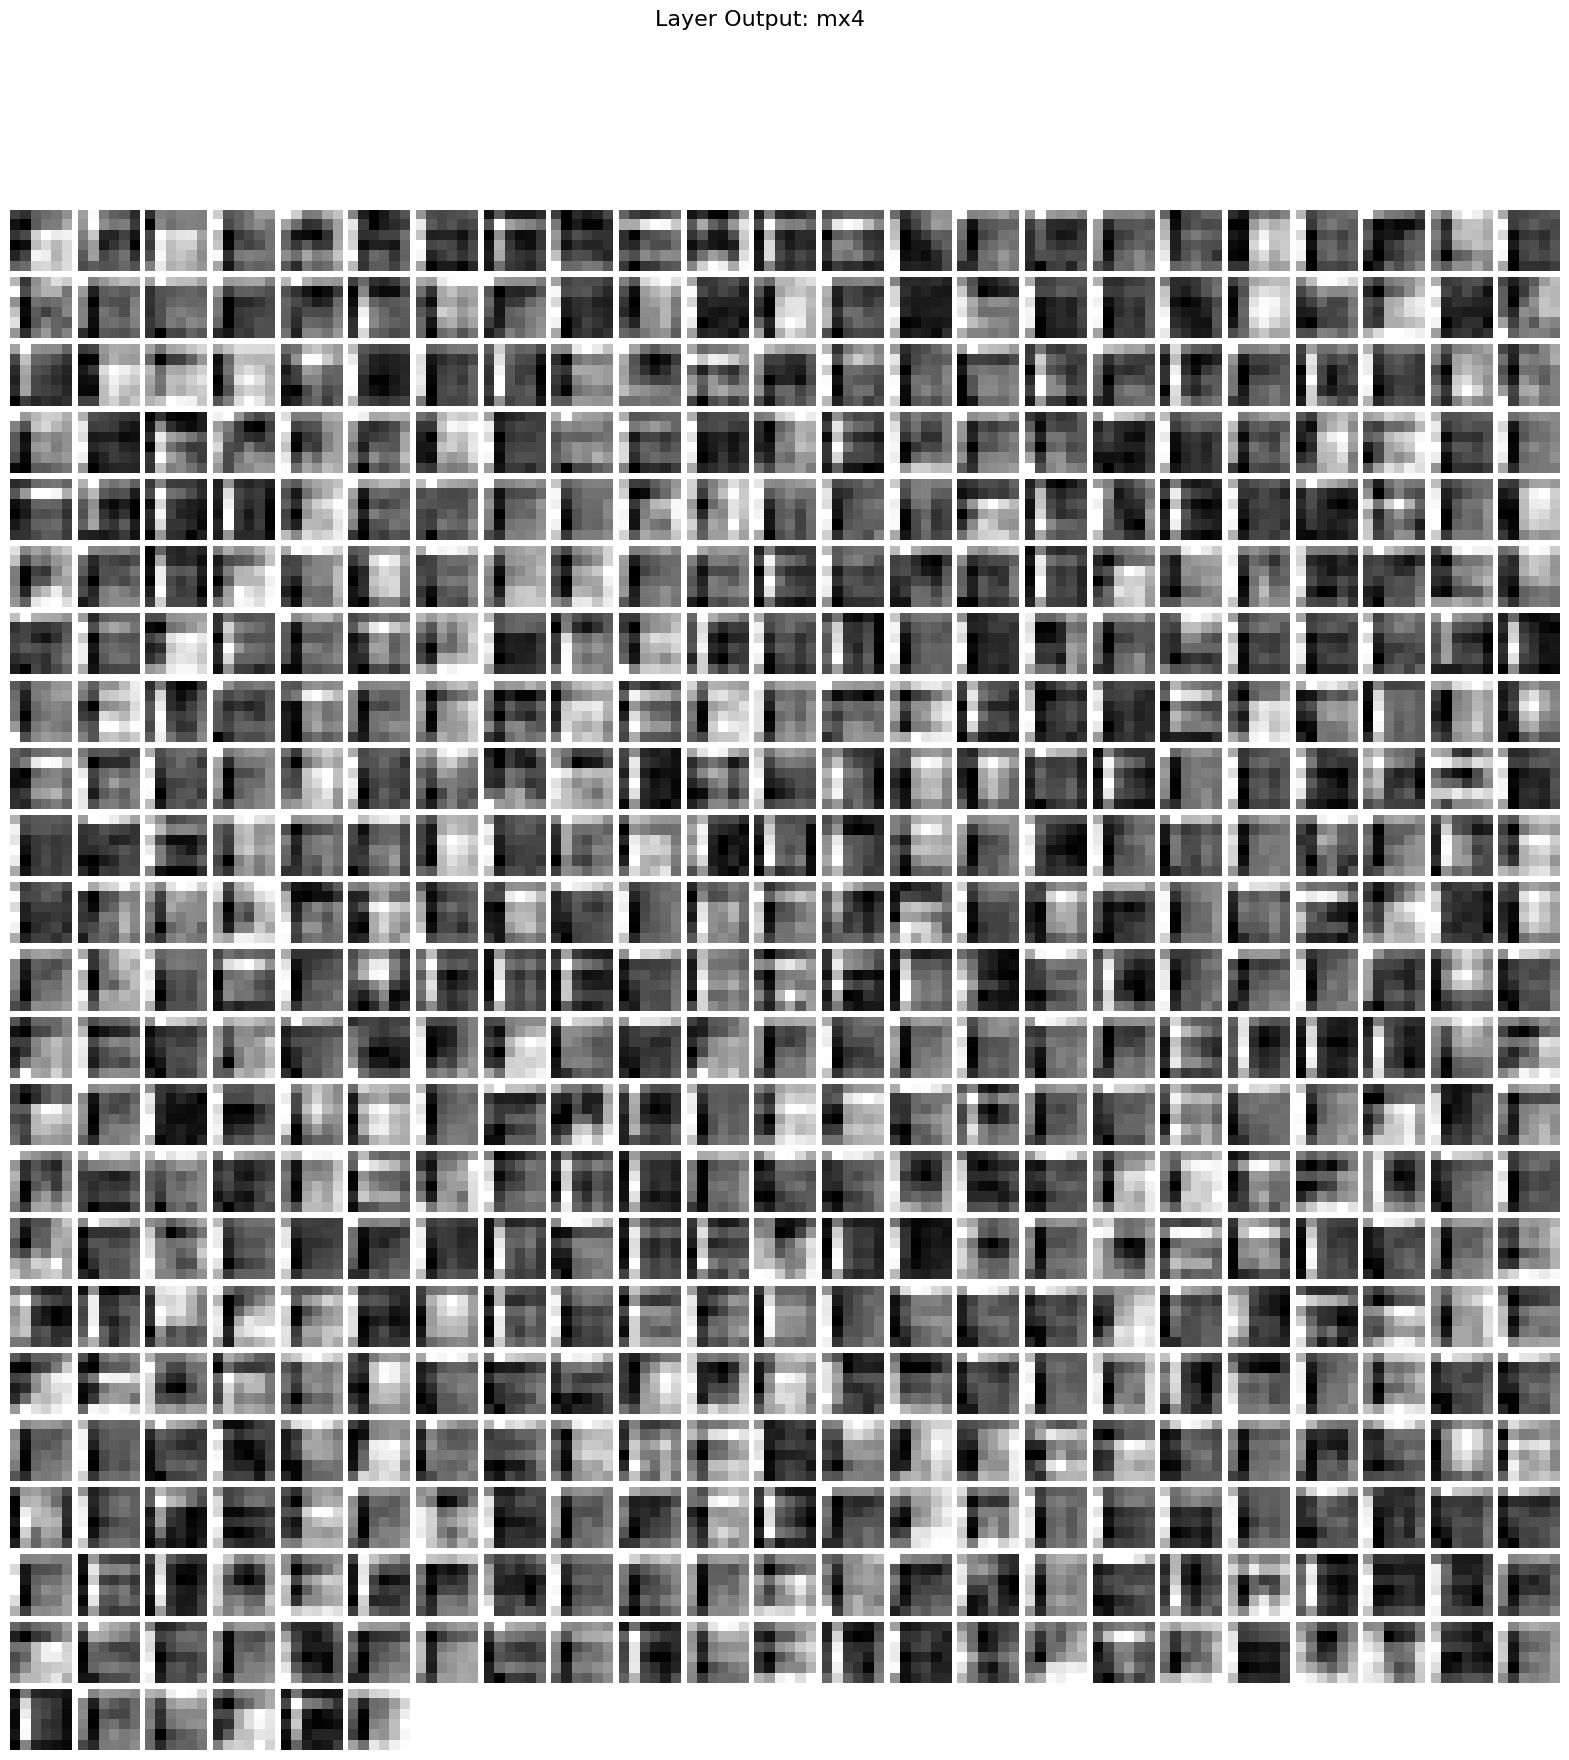

In [ ]:

def plot_output(output, figsize=(20, 20), title=None):
    output = output.squeeze(0)  # Remove the leading singleton dimension
    a, b, c = output.shape
    n_channels = c
    n_rows = int(np.ceil(np.sqrt(n_channels)))
    n_cols = int(np.ceil(n_channels / n_rows))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n_channels:
            ax.imshow(output[:, :, i], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    if title:
        fig.suptitle(title, fontsize=16)
    plt.show()

# Assuming you have the layer outputs as numpy arrays
layer_outputs = [cc1, lr1, cbn1, mx1, cc2, lr2, cbn2, mx2, cc3, lr3, cbn3, mx3, cc4, lr4, cbn4, mx4]
layer_names = ['cc1', 'lr1', 'cbn1', 'mx1', 'cc2', 'lr2', 'cbn2', 'mx2', 'cc3', 'lr3', 'cbn3', 'mx3', 'cc4', 'lr4', 'cbn4', 'mx4']

for output, name in zip(layer_outputs, layer_names):
    plot_output(output, title=f"Layer Output: {name}")

In [ ]:
print(cc1)

[[[[ 3.38312984e-02  2.55865548e-02 -4.91355499e-03 ... -2.98653245e-02
    -4.25397931e-03  1.93832323e-01]
   [ 3.36303711e-02  3.53528231e-01  9.63340104e-02 ... -2.01467108e-02
     6.34159818e-02  5.58881223e-01]
   [ 3.46790403e-02  3.52790326e-01  9.53407139e-02 ... -2.04942040e-02
     6.48216531e-02  5.58386385e-01]
   ...
   [ 3.60590927e-02  3.73284101e-01  1.01915419e-01 ... -2.13690531e-02
     6.76694959e-02  5.89535534e-01]
   [ 3.66488472e-02  3.71606857e-01  1.00980453e-01 ... -2.14679521e-02
     6.75320476e-02  5.89443743e-01]
   [-2.71149515e-03  2.72085965e-01  2.37082332e-01 ... -2.80737528e-03
    -2.94891722e-03  5.00225782e-01]]

  [[-5.14683127e-03 -3.96309933e-03 -2.09957338e-03 ... -6.93628145e-03
    -1.61474477e-02  1.56070277e-01]
   [-8.91163386e-03  2.36424804e-01  1.33195490e-01 ...  2.30484948e-01
    -3.32807121e-03  6.41400158e-01]
   [-8.92055687e-03  2.40531787e-01  1.33048251e-01 ...  2.31577232e-01
    -3.28148599e-03  6.43566906e-01]
   ...
   

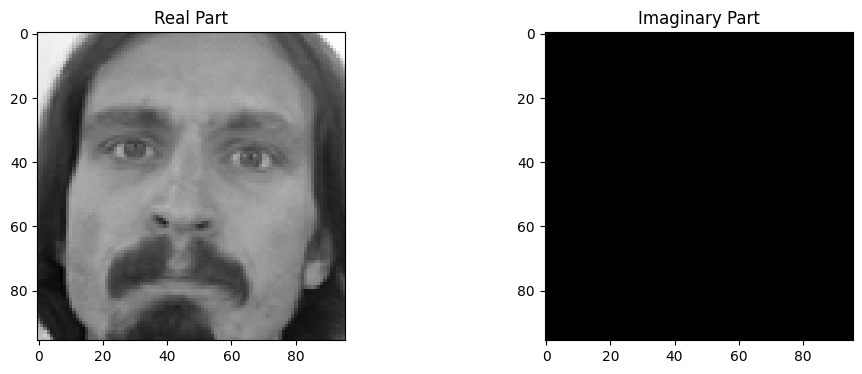

In [ ]:
image = X[0]  # Get the image data (96, 96, 2)

# Split the channels
real_part = image[:, :, 0]
imag_part = image[:, :, 1]

# Plot the real and imaginary parts
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(real_part, cmap='gray')
axes[0].set_title('Real Part')

axes[1].imshow(imag_part, cmap='gray')
axes[1].set_title('Imaginary Part')

plt.show()

In [ ]:
from complexnn.utils import get_imagpart, get_realpart

In [ ]:
def get_imagpart(x):
    image_format = K.image_data_format()
    ndim = len(K.shape(x))
    input_shape = K.shape(x)

    if (image_format == "channels_first" and ndim != 3) or ndim == 2:
        input_dim = input_shape[1] // 2
        return x[:, input_dim:]

    input_dim = input_shape[-1] // 2
    if ndim == 3:
        return x[:, :, input_dim:]
    elif ndim == 4:
        return x[:, :, :, input_dim:]
    elif ndim == 5:
        return x[:, :, :, :, input_dim:]

def get_realpart(x):
    image_format = K.image_data_format()
    ndim = len(K.shape(x))
    input_shape = K.shape(x)

    if (image_format == "channels_first" and ndim != 3) or ndim == 2:
        input_dim = input_shape[1] // 2
        return x[:, :input_dim]

    input_dim = input_shape[-1] // 2
    if ndim == 3:
        return x[:, :, :input_dim]
    elif ndim == 4:
        return x[:, :, :, :input_dim]
    elif ndim == 5:
        return x[:, :, :, :, :input_dim]

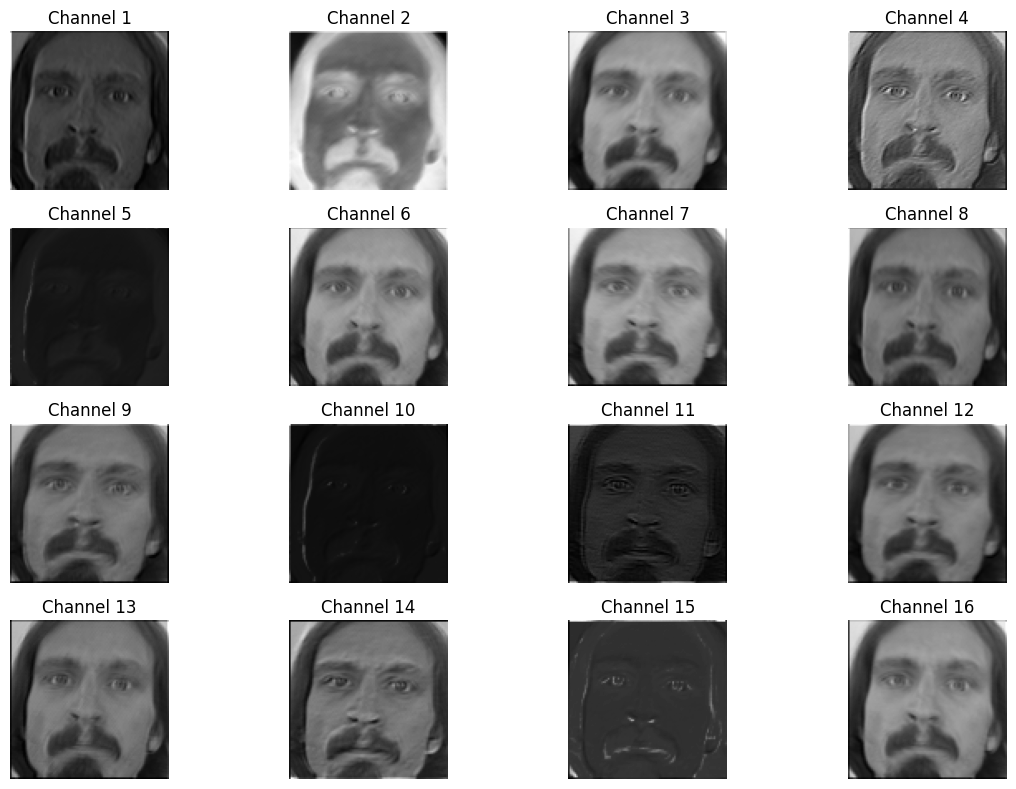

In [ ]:
imag = get_imagpart(cc1)

imag_data = imag[0, :, :, :]  # Extract the 3D data from the batch dimension

num_channels = imag_data.shape[-1]
fig, axs = plt.subplots(4, 4, figsize=(12, 8))  # Create a 4x4 grid of subplots
axs = axs.ravel()  # Flatten the axs array for easy indexing

for i in range(num_channels):
    channel_data = imag_data[:, :, i]  # Extract the 2D data for the current channel
    axs[i].imshow(channel_data, cmap='gray')
    axs[i].set_title(f'Channel {i+1}')
    axs[i].axis('off')

# Remove any unused subplots
for j in range(num_channels, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
cc1_real = get_realpart(cc1)
cc1_imag = get_imagpart(cc1)

lr1_real = get_realpart(lr1)
lr1_imag = get_imagpart(lr1)

cbn1_real = get_realpart(cbn1)
cbn1_imag = get_imagpart(cbn1)

mx1_real = get_realpart(mx1)
mx1_imag = get_imagpart(mx1)

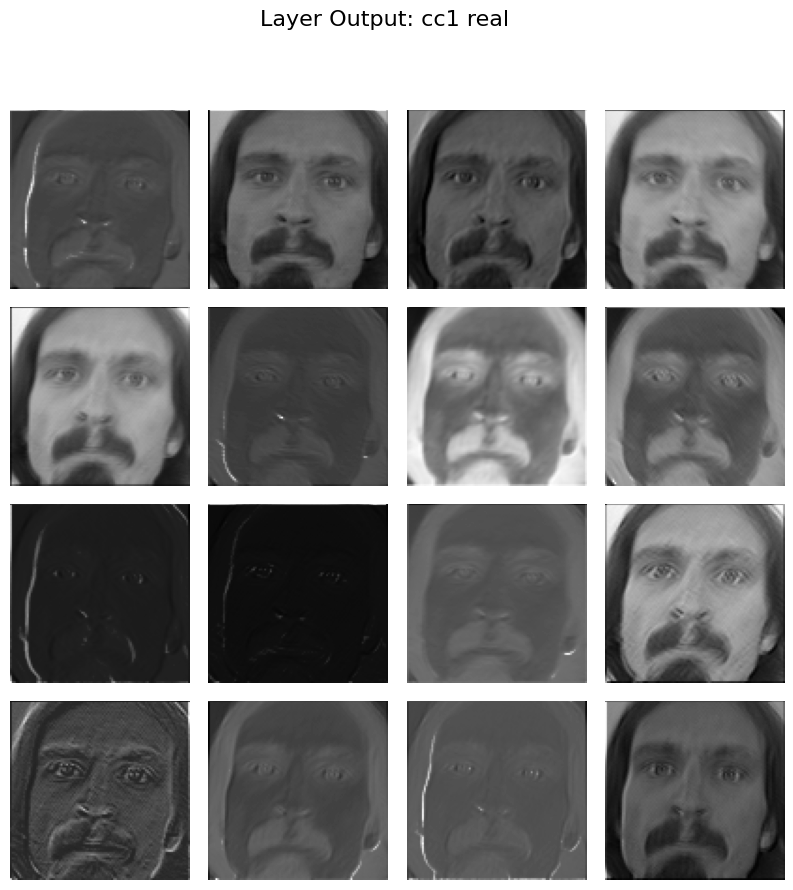

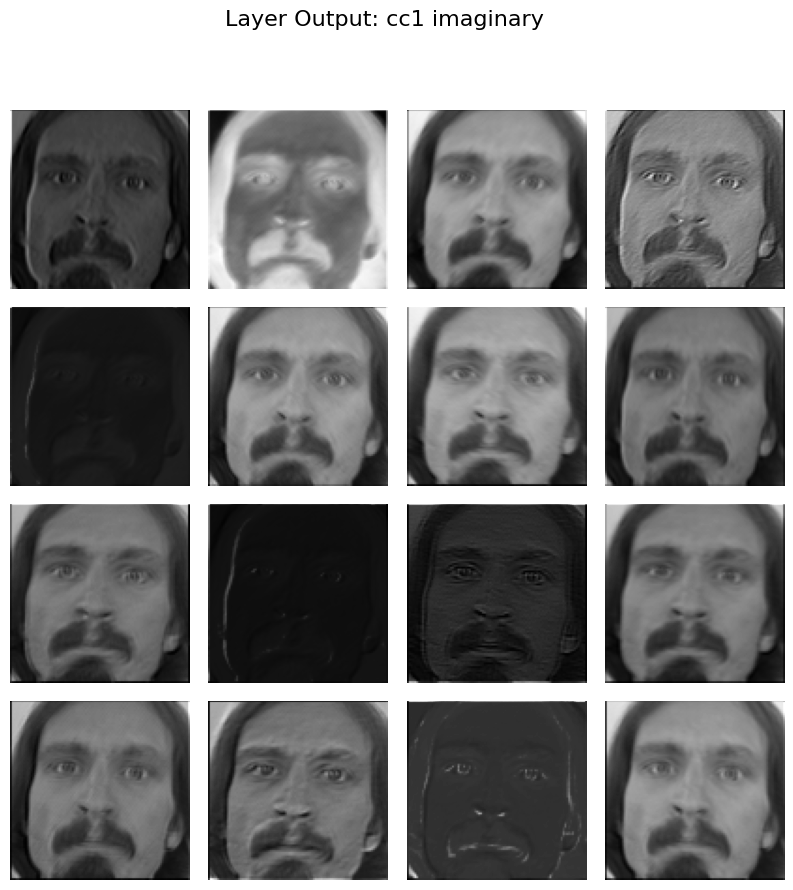

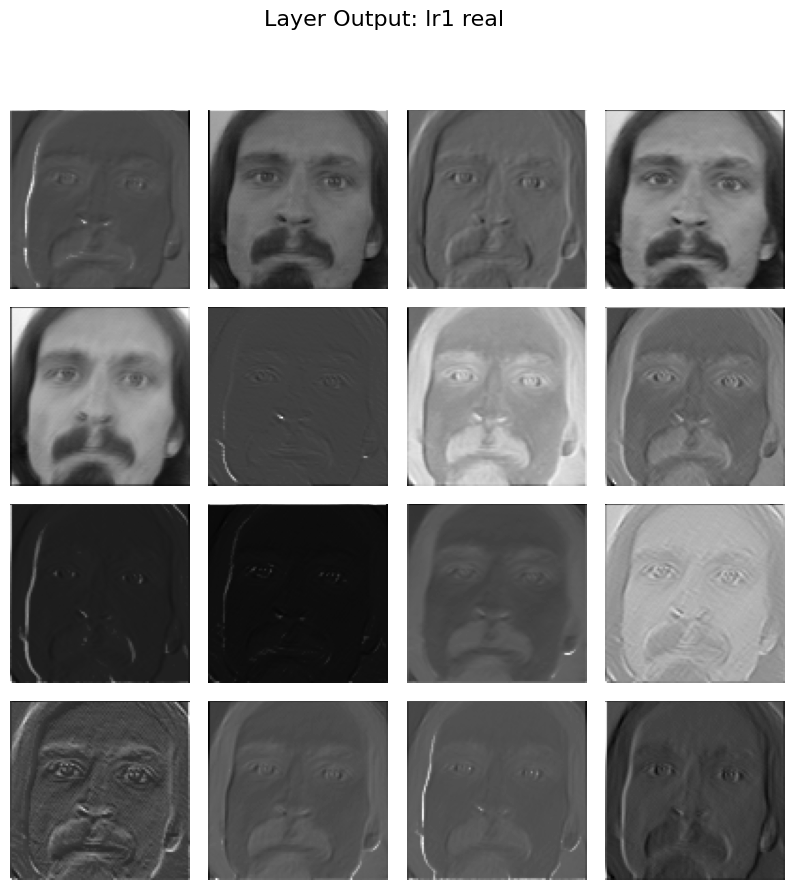

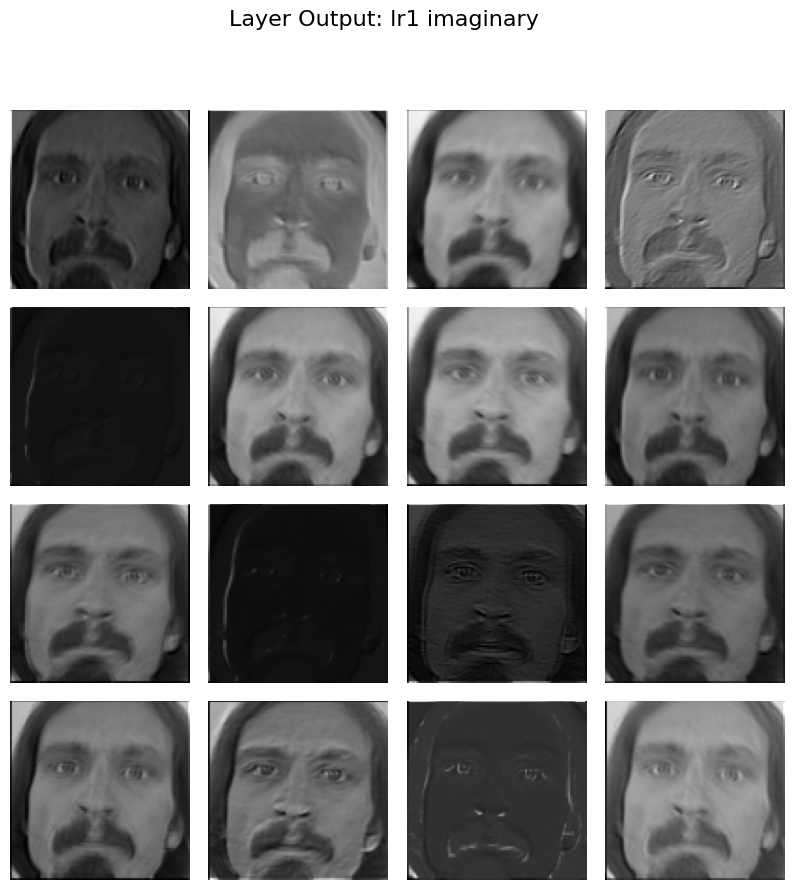

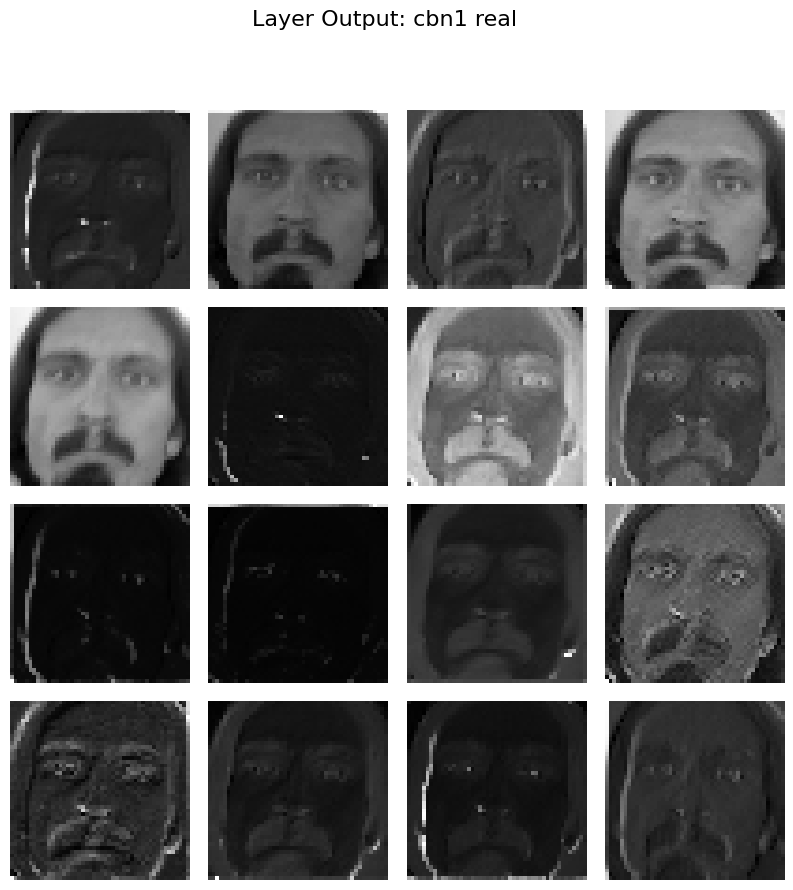

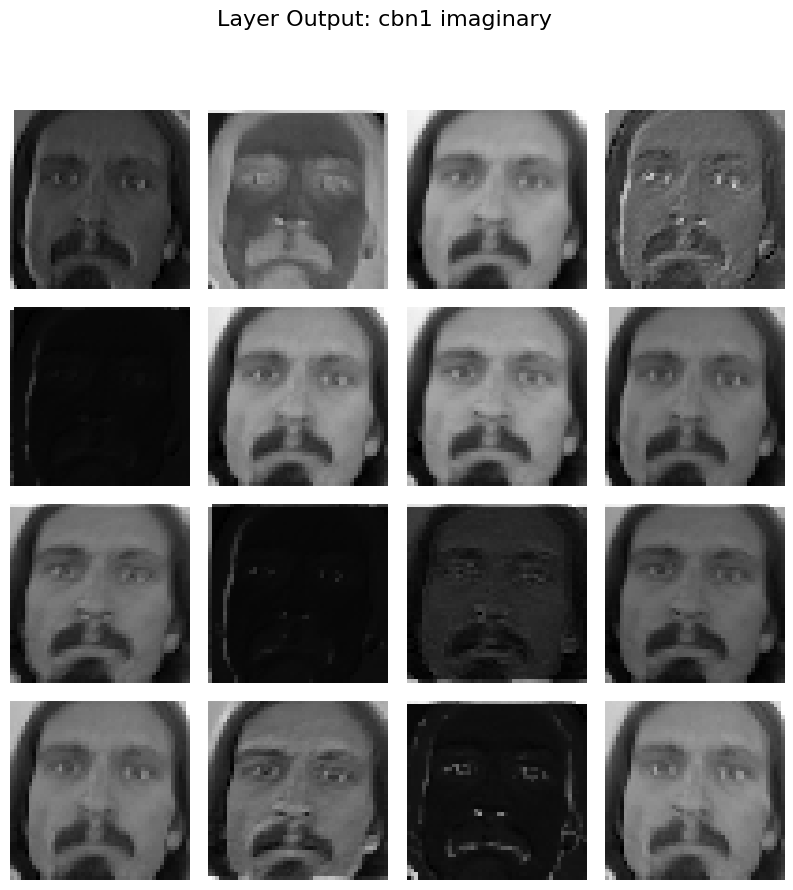

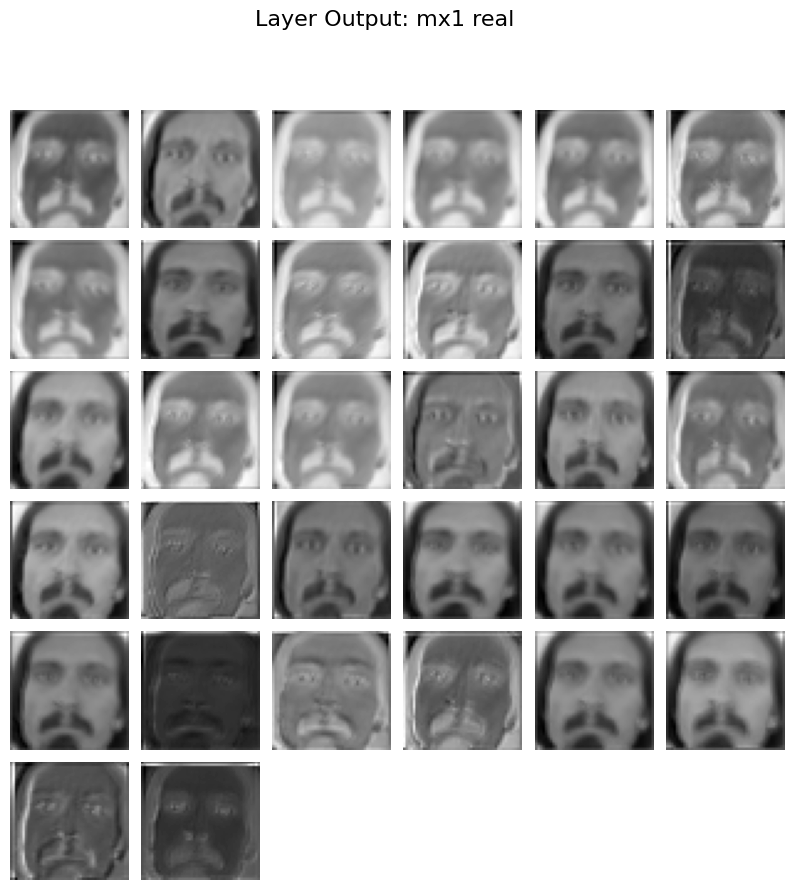

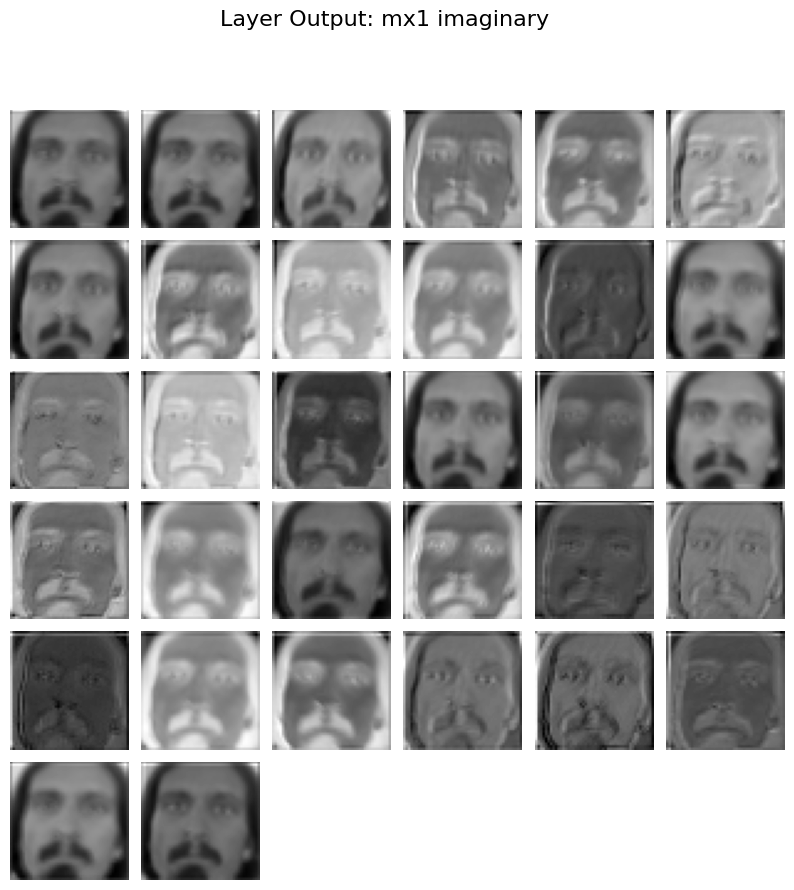

In [ ]:
layer_outputs = [cc1_real, cc1_imag, lr1_real, lr1_imag, cbn1_real, cbn1_imag, mx1_real, mx1_imag]
layer_names = ['cc1 real', 'cc1 imaginary', 'lr1 real', 'lr1 imaginary', 'cbn1 real', 'cbn1 imaginary', 'mx1 real', 'mx1 imaginary']

for output, name in zip(layer_outputs, layer_names):
    plot_output(output, (10,10), title=f"Layer Output: {name}")